In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import HOTS.libUnpackAtis as ua
import HOTS.libDataHelper as dh

from HOTS.Monitor import GenerateAM, DisplayAM
from HOTS.Event import Event, SimpleAlphabet, LoadGestureDB
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer, FilterNHBD
from HOTS.Monitor import DisplayImage, DisplaySurface3D, DisplaySurface2D, DisplayConvergence
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansHomeoCluster import KmeansHomeo
from HOTS.KmeansCluster2 import KmeansMaro2

In [3]:
settingsFile = "/Users/boutin.v/Documents/DataBase/GEST/newlayer_digit.hotsnetwork"
specs = dh.superLoadHOTSNetworkSettingsFromFile(settingsFile, True)
dbspecs = dh.superReadDB(specs.db_file, specs.db_path)

nb_dico = 14
R = 2
SpTe_Layer1 = STS(tau=0.03, R=R, verbose=0,initial_time=1)

------ Loaded settings ------
Enable viewer: True (Port: 3330, update 8)
 
Number of polarities of the input: 1
Number of dimensions and sizes: 2, [304 240]
Number of layers: 1
> 8, 10000.0, 2
Number of fixed layers: 0
 
Data file: none
DB file: /Users/boutin.v/Documents/DataBase/GEST/testoids_1.db
DB path: /Users/boutin.v/Documents/DataBase/GEST/complete_chris_db/
Workdir path: 
Save id: 
------ End of settings ------
 
840 files in the DB.


In [4]:
def learn(database,nb_file=None,verbose=0):
    res_list=list()
    coeff_list = list()
    #eta = 0.1
    if nb_file is None:
        nb_file = np.sum(np.array(database.dblabels) == 1)
    if verbose !=0:
        print('Training on {0} files'.format(nb_file))
    Prototype1 = np.random.rand(nb_dico,25)
    nb_proto = np.zeros(nb_dico)
    idx_train = 1
    for idf, dblabel in enumerate(database.dblabels):
        if dblabel == 1:
            
           
            if (verbose!=0) and (idx_train % 10 == 0):
                print('learned file {0}/{1}'.format(idx_train, nb_file))
           

            filepath = database.path + database.filenames[idf]
            event = LoadGestureDB(filepath, OutOnePolarity=True)
            Surface_Layer1 = SpTe_Layer1.create(event = event,kernel='linear')
            filt = np.sum(Surface_Layer1, axis = 1) > 2*R
            Surface_Layer2 = Surface_Layer1[filt,:] 

            res = np.zeros((Surface_Layer2.shape[0]))
            for idx, Si in enumerate(Surface_Layer2):
                Distance_to_proto = np.linalg.norm(Si - Prototype1,ord=2,axis=1)
                closest_proto_idx = np.argmin(Distance_to_proto)
                Ck = Prototype1[closest_proto_idx,:].copy()
                pk = nb_proto[closest_proto_idx]
                alpha = 1/(1+pk)
                beta = np.dot(Ck, Si)/(np.sqrt(np.dot(Si, Si))*np.sqrt(np.dot(Ck, Ck)))
                Ck_t = Ck + alpha*beta*(Si-Ck)
                res[idx] = np.linalg.norm(Si-Ck_t,ord=2)
                nb_proto[closest_proto_idx] += 1
                Prototype1[closest_proto_idx, :] = Ck_t
                coeff_list.append(alpha*beta)
            
            res_list.append(np.mean(res))
            if idx_train == nb_file:
                break
            idx_train+=1
    return Prototype1


In [5]:
Prototype1 = learn(dbspecs,verbose=1)

Training on 780 files
learned file 10/780
learned file 20/780
learned file 30/780
learned file 40/780
learned file 50/780
learned file 60/780
learned file 70/780
learned file 80/780
learned file 90/780
learned file 100/780
learned file 110/780
learned file 120/780
learned file 130/780
learned file 140/780
learned file 150/780
learned file 160/780
learned file 170/780
learned file 180/780
learned file 190/780
learned file 200/780
learned file 210/780
learned file 220/780
learned file 230/780
learned file 240/780
learned file 250/780
learned file 260/780
learned file 270/780
learned file 280/780
learned file 290/780
learned file 300/780
learned file 310/780
learned file 320/780
learned file 330/780
learned file 340/780
learned file 350/780
learned file 360/780
learned file 370/780
learned file 380/780
learned file 390/780
learned file 400/780
learned file 410/780
learned file 420/780
learned file 430/780
learned file 440/780
learned file 450/780
learned file 460/780
learned file 470/780


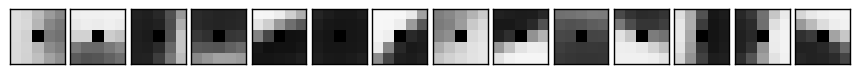

In [6]:
DisplaySurface2D(Prototype1,nb_polarities=1)

In [ ]:
def GenerateHistogram(dico, database, train=True, nb_file=None, verbose=0):
    if train == True and nb_file==None:
        nb_file = np.sum(np.array(database.dblabels) == 1)
    if train == False and nb_file==None:
        nb_file = np.sum(np.array(database.dblabels) == 2)
    if train== True:
        mode = 1
    else :
        mode = 2
        
    nb_dico = dico.shape[0]
    all_histo = np.zeros((nb_file,nb_dico))
    idx_train = 1
    for idf, dblabel in enumerate(database.dblabels):
        if dblabel == mode :
            if (verbose!=0) and (idx_train % 10 == 0):
                print('coded file {0}/{1}'.format(idx_train, nb_file))
            
            histo = np.zeros(nb_dico).astype(int)
            if idx_train % 10 == 0:
                print('file {0}/{1}'.format(idx_train, nb_file))

            filepath = database.path + database.filenames[idf]
            event = LoadGestureDB(filepath, OutOnePolarity=True)
            Surface_Layer1 = SpTe_Layer1.create(event = event,kernel='linear')
            filt = np.sum(Surface_Layer1, axis = 1) > 2*R
            Surface_Layer2 = Surface_Layer1[filt,:] 

            for idx, Si in enumerate(Surface_Layer2):
                Distance_to_proto = np.linalg.norm(Si - Prototype1,ord=2,axis=1)
                closest_proto_idx = np.argmin(Distance_to_proto)
                histo[closest_proto_idx] += 1

            all_histo[idx_train-1,:] = histo/np.sum(histo)
            if idx_train == nb_file:
                break
            idx_train+=1
    return (all_histo)

In [ ]:
GenerateHistogram(Prototype1,dbspecs,train=True,nb_file=20,verbose=1)

In [ ]:
test = np.array(dbspecs.labelids)
print(test.shape)

In [ ]:
np.array(database.dblabels) == 2)